In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile


DTMF = {
    (697, 1209): "1",
    (697, 1336): "2",
    (697, 1477): "3",
    (770, 1209): "4",
    (770, 1336): "5",
    (770, 1477): "6",
    (852, 1209): "7",
    (852, 1336): "8",
    (852, 1477): "9",
    (941, 1209): "*",
    (941, 1336): "0",
    (941, 1477): "#",
    (697, 1633): "A",
    (770, 1633): "B",
    (852, 1633): "C",
    (941, 1633): "D"
}

filename = 'clean_dialtone.wav'


use a mono .wav file (without metadata if possible - you can clear metadata when exporting with audacity)

In [45]:
sr, data = wavfile.read(filename)
data = np.array(data)
duration = len(data)/sr
print(f'{len(data)} frames, sr = {sr}, length = {duration} s.')


661510 frames, sr = 44100, length = 15.000226757369614 s.


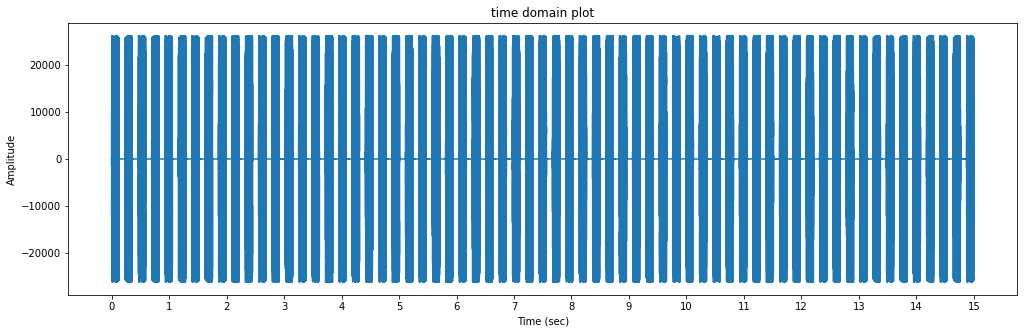

In [46]:
def plot_time_domain(data, sr):
    ts_orig = np.arange(0, len(data), sr)
    ts_sec = np.arange(0, len(ts_orig), 1)
    plt.figure(figsize=(17, 5))
    plt.plot(data)
    plt.xticks(ts_orig, ts_sec)
    plt.xlabel("Time (sec)")
    plt.ylabel("Amplitude")
    plt.title("time domain plot")
    plt.show()


plot_time_domain(data, sr)


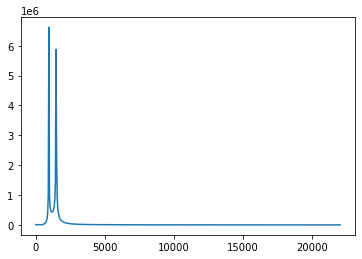

[1464.2578125  947.4609375]


In [76]:
chunk_size = 1024
start = chunk_size * 4 
sig = data[start:start + chunk_size]
yf = np.abs(np.fft.rfft(sig))
xf = np.fft.rfftfreq(1024, d = 1 / sr)
max_amps = np.argpartition(yf, -2)[-2:]
freqs = xf[max_amps] 
plt.plot(xf, yf)
plt.show()

# ifreqs = np.where(np.log10(np.abs(yf)) > 0)

print(freqs)



In [77]:
import bisect
def get_vals(freqs_raw, amps_raw):
  ifreqs = np.where(freqs_raw > 0)
  freqs = freqs_raw[ifreqs]
  amps = amps_raw[ifreqs]
  pick = freqs > 500
  pick = np.logical_and(pick, freqs < 1490)
  return freqs[pick], np.abs(amps[pick])

def process_chunk(sig):
  yf = np.abs(np.fft.rfft(sig))
  xf = np.fft.rfftfreq(1024, d = 1 / sr)
  max_amps = np.argpartition(yf, -2)[-2:]
  freqs = xf[max_amps] 
  max_freq, min_freq = freqs
  if max_freq < min_freq:
    min_freq, max_freq = freqs
  return max_freq, min_freq
  
def snap(choices, val):
    ix = bisect.bisect_right(choices, val)
    if ix == 0:
        return choices[0]
    elif ix == len(choices):
        return choices[-1]
    else:
        return min(choices[ix - 1], choices[ix], key=lambda gridValue: abs(gridValue - val))

def snap_value(choices, val, best):
  delta = precision
  best = best
  for f in choices:
    diff = abs(val - f)
    if diff < delta:
      delta = diff
      best = f
  return best

  
chunk_size = 1024
precision = 100

i = 0


msg = ''
current_tone = ''

while i < len(data) - chunk_size:
    sig = data[i:i + chunk_size]
    max_freq, min_freq = process_chunk(sig)
    if not max_freq:
      i += chunk_size
      continue
    

    max_freq = snap_value([1209, 1336, 1477, 1633], max_freq, 1209)
    min_freq = snap_value([697, 779, 852, 941], min_freq, 697)

    t = DTMF.get((min_freq, max_freq), None)
    

    if t and t != current_tone:

      current_tone = t
      msg += t
    i += chunk_size
# print([int(x) for x in msg.split('*') if x])
print(msg)

#1*1#1*13#A1*1*#1*13#12171#1#718101#18*121#17131#171#17191#18121#317181#19121#2131#191#7191#10A1#31*1#*1#1*71#21*1#*1*1#31*21#


654921.3


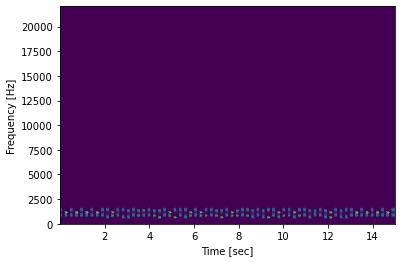

In [83]:
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt 

rng = np.random.default_rng()

fs = 10e3

f, t, Sxx = signal.spectrogram(data, 44100)

plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()